# Plot Morphologies

In [1]:
import sys, os, json, pandas
import numpy as np

sys.path.append('../neural_network_dynamics/')
import nrn
from nrn.plot import nrnvyz

sys.path.append('..')
import plot_tools as pt
import matplotlib.pylab as plt

 /!\  "svgutils" not installed ! get it with: "pip install svgutils" 


## 1) Load and build dataset

In [2]:
datafolder = '../data/SchneiderMizell_et_al_2023'
DATASET = {}

for key in os.listdir(datafolder):
    if 'csv' in key:
        DATASET[key.replace('.csv', '')] = pandas.read_csv('../data/SchneiderMizell_et_al_2023/%s' % key)
        
# ID of the two cell types of interest:
for cType in ['MC', 'BC']:
    DATASET['%s_id' % cType] = DATASET['cell_types']['pt_root_id'][DATASET['cell_types']['cell_type_manual']==cType]
    
# need to correct the swc files bur thei use in brian2
def swc_correction(ID):
    """
    a small correction to replace the 'dendrite' label
    for the soma in the allen swc files (3 is replaced by 1)
    """
    fixed = ''
    with open(os.path.join(datafolder, 'skeletons' , 'swc', '%s.swc'%ID), "r") as file:
        for i, line in enumerate(file):
            if i==0:
                fixed += '0 1 '+line[4:]
            else:
                fixed += line
    with open(os.path.join(datafolder, 'skeletons' , '_fixed', '%s.swc'%ID), 'w') as f:
        f.write(fixed)
        
for cType in ['MC', 'BC']:
    for i, ID in enumerate(DATASET['%s_id' % cType]):
        swc_correction(ID)

In [3]:
print(DATASET.keys())
DATASET['cell_types']

dict_keys(['cell_types', 'inhibitory_synapses_onto_column', 'all_input_synapses', 'nonneuronal_cells', 'excitatory_properties', 'MC_id', 'BC_id'])


,Unnamed: 0,pt_root_id,cell_id,m_type,cell_type_manual,pt_position_um_x,pt_position_um_y,pt_position_um_z
0,0,864691135687112672,262825,L4c,4P,648.871757,374.743206,857.12
1,1,864691135162584621,298868,L4a,5P-IT,658.495023,377.833689,871.28
2,2,864691135988284416,298828,L4a,5P-IT,702.888652,382.231584,816.16
3,3,864691135476384680,298945,L4a,5P-IT,695.170942,382.327305,864.80
4,4,864691135590240523,299071,L4c,5P-IT,684.634392,381.598210,898.24
...,...,...,...,...,...,...,...,...
1341,1341,864691135058985115,269585,DTC,MC,611.953530,508.867955,919.80
1342,1342,864691135468031628,307287,DTC,Unsure I,651.601783,627.719795,974.16
1343,1343,864691135355455183,307126,STC,Unsure I,671.966250,616.716806,908.88
1344,1344,864691136118890776,305048,PTC,BC,663.755799,526.248960,889.12


## 2) Plot all morphologies

In [4]:
def plot_all_morphologies(cType, Nx = 4,
                          dendrite_color='k',
                          axon_color='tab:blue'):
    
    Ny = int(len(DATASET['%s_id' % cType]) / Nx)
    
    fig, AX = pt.plt.subplots(Ny+1, Nx, figsize=(1.7*Nx, 1.4*Ny))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    for i, ID in enumerate(DATASET['%s_id' % cType]):
        morpho = nrn.Morphology.from_swc_file(os.path.join(datafolder,
                                                           'skeletons', '_fixed', '%s.swc'%ID))
        SEGMENTS = nrn.morpho_analysis.compute_segments(morpho)
        vis = nrnvyz(SEGMENTS)
        if axon_color is not None:
            vis.plot_segments(cond=(SEGMENTS['comp_type']=='axon'),
                              color=axon_color,
                              bar_scale_args={'Ybar':100, 'Xbar':1e-9,
                                              'Ybar_label':'100$\mu$m ', 'fontsize':6},
                              ax=AX[int(i/Nx)][i%Nx])
        vis.plot_segments(cond=(SEGMENTS['comp_type']!='axon'),
                          color=dendrite_color,
                          bar_scale_args=None,
                          ax=AX[int(i/Nx)][i%Nx])

        AX[int(i/Nx)][i%Nx].set_title('%i ) %s' % (i+1, ID), fontsize=6)

    while i<(Nx*(Ny+1)-1):
        i+=1
        AX[int(i/Nx)][i%Nx].axis('off')
    AX[-1][-1].annotate('dendrite', (0,1), xycoords='axes fraction', va='top', color=dendrite_color)
    AX[-1][-1].annotate('\naxon', (0,1), xycoords='axes fraction', va='top', color=axon_color)
    
    return fig, AX

In [15]:
np.array(DATASET['MC_id'])[19]

864691135687245024

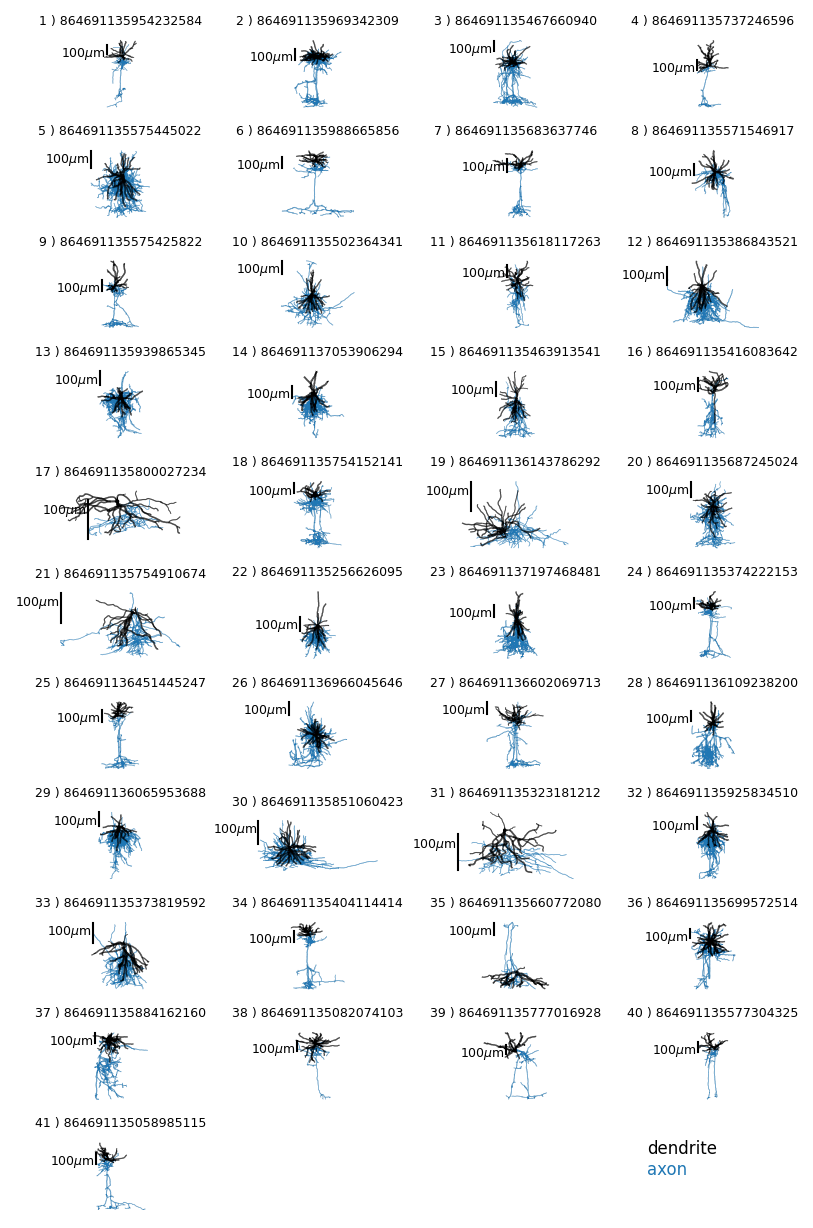

In [5]:
fig, AX = plot_all_morphologies('MC')#, axon_color=None)
fig.savefig('../figures/all_Martinotti_cells_morphologies.svg')

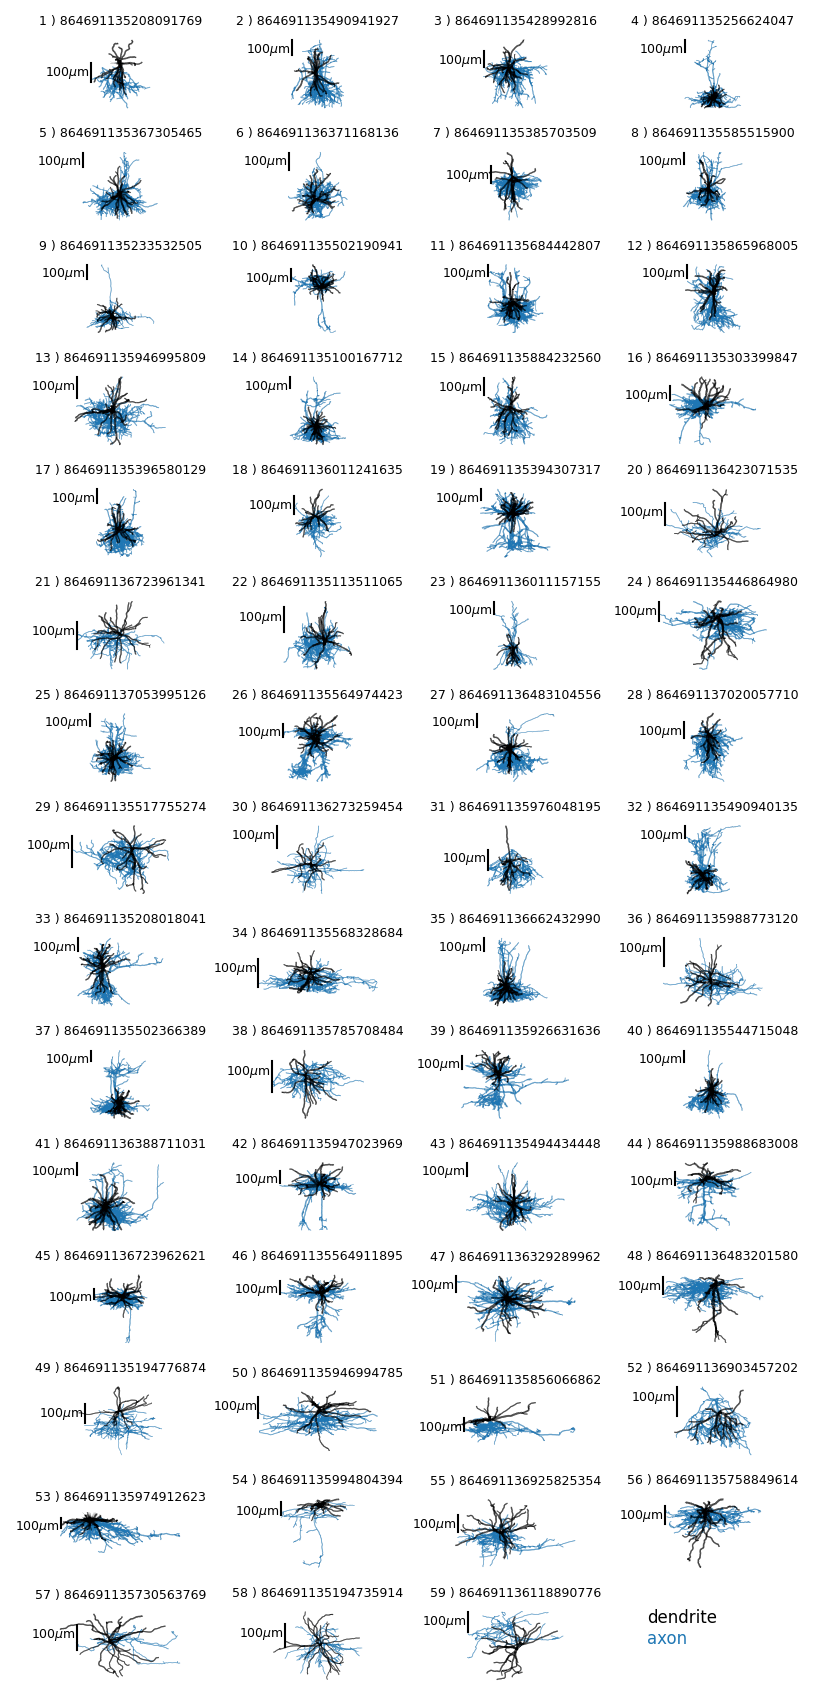

In [6]:
fig, AX = plot_all_morphologies('BC')#, axon_color=None)
fig.savefig('../figures/all_Basket_cells_morphologies.svg')

## Basket cell example

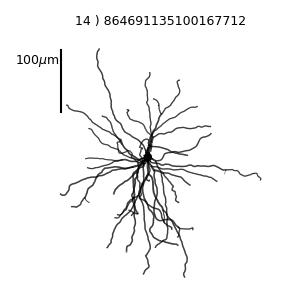

In [7]:
BC_example_ID = 864691135100167712
BC_example_index = np.flatnonzero(np.array(DATASET['BC_id'],dtype=int)==BC_example_ID)[0]

morpho = nrn.Morphology.from_swc_file(os.path.join(datafolder,
                                                   'skeletons', '_fixed', '%s.swc' % BC_example_ID))
SEGMENTS = nrn.morpho_analysis.compute_segments(morpho)
vis = nrnvyz(SEGMENTS)
vis.plot_segments(cond=(SEGMENTS['comp_type']!='axon'),
                  bar_scale_args={'Ybar':100, 'Xbar':1e-9,
                                              'Ybar_label':'100$\mu$m ', 'fontsize':6})
plt.gca().set_title('%i ) %s' % (BC_example_index+1, BC_example_ID), fontsize=6)

fig.savefig('../figures/Basket_cell_example_dendrite.svg')

## Martinotti cell example

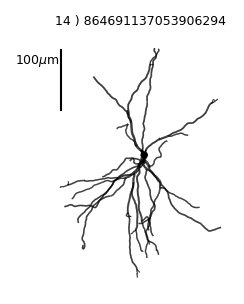

In [8]:
MC_example_ID = 864691137053906294
MC_example_index = np.flatnonzero(np.array(DATASET['MC_id'],dtype=int)==MC_example_ID)[0]

morpho = nrn.Morphology.from_swc_file(os.path.join(datafolder,
                                                   'skeletons', '_fixed', '%s.swc' % MC_example_ID))
SEGMENTS = nrn.morpho_analysis.compute_segments(morpho)
vis = nrnvyz(SEGMENTS)
vis.plot_segments(cond=(SEGMENTS['comp_type']!='axon'),
                  bar_scale_args={'Ybar':100, 'Xbar':1e-9,
                                  'Ybar_label':'100$\mu$m ', 'fontsize':6})
plt.gca().set_title('%i ) %s' % (MC_example_index+1, MC_example_ID), fontsize=6)

plt.savefig('../figures/Martinotti_cell_example_dendrite.svg')